In [13]:
import pathlib
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, roc_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.stats import gaussian_kde
from tabpfn import TabPFNClassifier

# TabPFN Extensions for SHAP-based feature importance
try:
    from tabpfn_extensions import interpretability
    TABPFN_EXTENSIONS_AVAILABLE = True
except ImportError:
    print("WARNING: tabpfn_extensions not installed. SHAP-based feature importance disabled.")
    print("Install with: pip install tabpfn-extensions")
    TABPFN_EXTENSIONS_AVAILABLE = False

import warnings
warnings.filterwarnings('ignore')

# Utility functions
def _slug(s):
    return re.sub(r"[^-a-zA-Z0-9_.]+", "_", str(s)).strip("_")

def save_prob_density(probs_dict, mean_line=None, title="", out_path="", ylog=False):
    x = np.linspace(0, 1, 200)
    plt.figure(figsize=(7,5))
    for label, arr, color in probs_dict:
        if len(arr) > 1:
            kde = gaussian_kde(arr)
            plt.plot(x, kde(x), label=label, color=color)
    if mean_line is not None:
        plt.axvline(mean_line, linestyle="--", alpha=0.8, label=f"Drug mean = {mean_line:.3f}", color="black")
    if ylog:
        plt.yscale("log"); plt.ylabel("Density (log)")
    else:
        plt.ylabel("Density")
    plt.xlabel("P(Control)"); plt.title(title); plt.legend()
    plt.tight_layout(); plt.savefig(out_path, dpi=300, bbox_inches="tight"); plt.close()

def save_cm(y_true, y_pred, out_path, title):
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    plt.figure(figsize=(5.5,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Pred: Control','Pred: Patient'],
                yticklabels=['True: Control','True: Patient'])
    plt.title(title); plt.tight_layout()
    plt.savefig(out_path, dpi=300, bbox_inches="tight"); plt.close()

def save_roc(y_true, y_prob, out_path, title):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc = roc_auc_score(y_true, y_prob)
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title(title); plt.legend(); plt.tight_layout()
    plt.savefig(out_path, dpi=300, bbox_inches="tight"); plt.close()

def load_feature_cols(results_dir, group_size):
    """Load the feature list used during training"""
    feat_path = results_dir / f"selected_features_group{group_size}.json"
    if not feat_path.exists():
        raise FileNotFoundError(f"Feature file not found: {feat_path}")
    with open(feat_path, "r") as f:
        data = json.load(f)
    if isinstance(data, list):
        cols = data
    elif isinstance(data, dict):
        for key in ("feature_cols_final", "selected_features", "features", "feature_list", "columns"):
            if key in data:
                cols = data[key]
                break
        else:
            raise ValueError(f"Could not find expected keys in {feat_path}")
    else:
        raise ValueError(f"Unexpected JSON format in {feat_path}")
    cols = [str(c) for c in cols]
    if len(cols) == 0:
        raise ValueError(f"Empty feature list in {feat_path}")
    return cols

# ==================== QUALITY CONTROL FUNCTIONS ====================

def calculate_qc_metrics(neuron_counts):
    """Calculate comprehensive QC metrics for well filtering"""
    metrics = {
        'mean': np.mean(neuron_counts),
        'median': np.median(neuron_counts),
        'std': np.std(neuron_counts),
        'mad': np.median(np.abs(neuron_counts - np.median(neuron_counts))),
        'q1': np.percentile(neuron_counts, 25),
        'q3': np.percentile(neuron_counts, 75),
        'iqr': np.percentile(neuron_counts, 75) - np.percentile(neuron_counts, 25),
        'min': np.min(neuron_counts),
        'max': np.max(neuron_counts),
    }
    return metrics

def filter_wells_by_mad(neuron_counts, threshold_mad=3.0):
    """Filter wells using Median Absolute Deviation (MAD)"""
    median = np.median(neuron_counts)
    mad = np.median(np.abs(neuron_counts - median))
    if mad == 0:
        mad = 1.4826 * np.std(neuron_counts)
    modified_z_scores = 0.6745 * (neuron_counts - median) / mad
    good_wells_mask = np.abs(modified_z_scores) <= threshold_mad
    return good_wells_mask

def apply_rigorous_qc(df, threshold=2.0, min_neurons_per_well=0, plot_dir=None):
    """Apply rigorous quality control to filter wells using MAD method"""
    well_counts = df.groupby("Plate_Well").size()
    wells = well_counts.index
    counts = well_counts.values
    
    # Apply minimum threshold if specified
    if min_neurons_per_well > 0:
        min_mask = counts >= min_neurons_per_well
        counts_after_min = counts[min_mask]
        wells_after_min = wells[min_mask]
    else:
        counts_after_min = counts
        wells_after_min = wells
    
    # Calculate QC metrics
    metrics = calculate_qc_metrics(counts)
    
    # Apply MAD filtering
    good_mask = filter_wells_by_mad(counts_after_min, threshold_mad=threshold)
    method_name = f"MAD (threshold={threshold})"
    
    good_wells = wells_after_min[good_mask]
    filtered_df = df[df["Plate_Well"].isin(good_wells)].copy()
    
    qc_report = {
        'method': method_name,
        'min_neurons_threshold': min_neurons_per_well,
        'total_wells': len(wells),
        'wells_kept': len(good_wells),
        'wells_filtered': len(wells) - len(good_wells),
        'wells_filtered_by_min_threshold': len(wells) - len(wells_after_min) if min_neurons_per_well > 0 else 0,
        'wells_filtered_by_statistical': len(wells_after_min) - len(good_wells),
        'filter_rate': (len(wells) - len(good_wells)) / len(wells),
        'metrics_before': metrics,
        'metrics_after': calculate_qc_metrics(counts_after_min[good_mask]),
    }
    
    if plot_dir is not None:
        plot_dir = pathlib.Path(plot_dir)
        plot_dir.mkdir(parents=True, exist_ok=True)
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Get final counts after QC
        counts_final = counts_after_min[good_mask]
        final_good_mask = np.array([w in good_wells for w in wells])
        
        axes[0, 0].hist(counts, bins=50, alpha=0.7, label='Before QC', edgecolor='black')
        axes[0, 0].hist(counts_final, bins=50, alpha=0.7, label='After QC', edgecolor='black')
        axes[0, 0].axvline(np.median(counts), color='red', linestyle='--', label=f"Median: {np.median(counts):.0f}")
        axes[0, 0].set_xlabel('Neurons per Well'); axes[0, 0].set_ylabel('Number of Wells')
        axes[0, 0].set_title(f'Neuron Distribution: {method_name}'); axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        axes[0, 1].boxplot([counts, counts_final], labels=['Before QC', 'After QC'])
        axes[0, 1].set_ylabel('Neurons per Well'); axes[0, 1].set_title('Box Plot Comparison')
        axes[0, 1].grid(True, alpha=0.3)
        
        well_indices = np.arange(len(counts))
        colors = ['green' if m else 'red' for m in final_good_mask]
        axes[1, 0].scatter(well_indices, counts, c=colors, alpha=0.6)
        axes[1, 0].axhline(metrics['median'], color='blue', linestyle='--', label='Median')
        axes[1, 0].axhline(metrics['median'] - threshold*metrics['mad'], color='orange', linestyle='--', label=f'±{threshold} MAD')
        axes[1, 0].axhline(metrics['median'] + threshold*metrics['mad'], color='orange', linestyle='--')
        axes[1, 0].set_xlabel('Well Index'); axes[1, 0].set_ylabel('Neurons per Well')
        axes[1, 0].set_title('MAD Outlier Detection (Green=Keep, Red=Filter)'); axes[1, 0].legend()
        axes[1, 0].grid(True, alpha=0.3)
        
        sorted_before = np.sort(counts)
        sorted_after = np.sort(counts_final)
        cumsum_before = np.arange(1, len(sorted_before) + 1) / len(sorted_before) * 100
        cumsum_after = np.arange(1, len(sorted_after) + 1) / len(sorted_after) * 100
        axes[1, 1].plot(sorted_before, cumsum_before, label='Before QC', linewidth=2)
        axes[1, 1].plot(sorted_after, cumsum_after, label='After QC', linewidth=2)
        axes[1, 1].set_xlabel('Neurons per Well'); axes[1, 1].set_ylabel('Cumulative % of Wells')
        axes[1, 1].set_title('Cumulative Distribution'); axes[1, 1].legend(); axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(plot_dir / 'qc_analysis_mad.png', dpi=300, bbox_inches='tight')
        plt.close()
    
    return filtered_df, qc_report

# ==================== FEATURE IMPORTANCE FUNCTIONS ====================

def calculate_shap_importance(model, X, y, feature_names, n_samples=100):
    """Calculate SHAP-based feature importance using TabPFN extensions"""
    if not TABPFN_EXTENSIONS_AVAILABLE:
        print("WARNING: tabpfn_extensions not available. SHAP importance disabled.")
        return None, None
    
    try:
        print(f"Calculating SHAP values for {n_samples} samples...")
        print("WARNING: This may run slowly on CPU-only systems.")
        
        shap_values = interpretability.shap.get_shap_values(
            estimator=model,
            test_x=X[:n_samples],
            attribute_names=feature_names,
            algorithm="permutation",
        )
        
        mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
        
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'shap_importance': mean_abs_shap,
        }).sort_values('shap_importance', ascending=False)
        
        print(f"SHAP calculation complete!")
        return shap_values, importance_df
        
    except Exception as e:
        print(f"SHAP calculation failed: {e}")
        return None, None

def save_shap_plots(shap_values, out_path, title="SHAP Feature Importance"):
    """Save SHAP visualization plots"""
    if shap_values is None:
        return
    
    try:
        fig = interpretability.shap.plot_shap(shap_values)
        if fig is not None:
            fig.suptitle(title, fontsize=14, y=0.98)
            fig.savefig(out_path, dpi=300, bbox_inches='tight')
            plt.close(fig)
            print(f"SHAP plot saved to: {out_path}")
    except Exception as e:
        print(f"Failed to save SHAP plot: {e}")

print("Simplified utility functions loaded successfully!")

Simplified utility functions loaded successfully!


In [14]:
print("=== TabPFN Validation Notebook ===\n")

# Paths
data_dir = pathlib.Path(r"D:\pycytominer\microsam_features").resolve(strict=True)
results_dir = pathlib.Path("D:/tabPFN")
validation_results_dir = results_dir / "validation"
validation_results_dir.mkdir(parents=True, exist_ok=True)

# Test group sizes (same as training)
test_group_sizes = [50, 60, 70, 80, 90, 100]

# Validation data
feature_csv = data_dir / "Xu_BA071_CP_1_annotate_file.csv"
design_csv = data_dir / "design" / "10-16-2024_design_BX.csv"

# Feature definitions
neurite_features = [
    "N_node","Soma_surface","N_stem","Number_of_Nodes","Soma_Surface","Number_of_Stems",
    "Number_of_Bifurcations","Number_of_Branches","Number_of_Tips","Overall_Width",
    "Overall_Height","Average_Diameter","Total_Length","Total_Surface","Total_Volume",
    "Max_Euclidean_Distance","Max_Path_Distance","Max_Branch_Order","Average_Contraction",
    "Average_Fragmentation","Average_PD_Ratio","Avg_Bif_Angle_Local","Avg_Bif_Angle_Remote",
    "Hausdorff_Dimension",
]

metadata_cols = ["SampleID","Genotype","Treatment","Dosage","DrugID","Plate","Row","Col","Plate_Well"]

# Quality Control parameters (using MAD method only)
qc_threshold = 2.0  # MAD threshold for outlier detection
min_neurons_per_well = 0  # Minimum neurons per well (set to 0 to disable, should match training)

random_seed = 42

print(f"Validation data: {feature_csv.name}")
print(f"Design file: {design_csv.name}")
print(f"Group sizes to test: {test_group_sizes}")

=== TabPFN Validation Notebook ===

Validation data: Xu_BA071_CP_1_annotate_file.csv
Design file: 10-16-2024_design_BX.csv
Group sizes to test: [50, 60, 70, 80, 90, 100]


In [15]:
print("\n=== Loading Validation Data ===")

# Load design
design_df = pd.read_csv(design_csv, dtype=str)
for c in ["Plate_ID","Well_ID","Row","Col","SampleID","Genotype","Treatment","Dosage","DrugID"]:
    if c in design_df.columns:
        design_df[c] = design_df[c].astype(str).str.strip()
design_df["Well_ID"] = design_df["Well_ID"].str.upper()
design_df["Plate_ID"] = design_df["Plate_ID"].str.lower()

# Load features
print("Loading neurite data...")
df = pd.read_csv(feature_csv, dtype=str)

# Extract plate number
m = re.search(r"CP_(\d+)", feature_csv.name)
if m is None:
    raise ValueError(f"Cannot read plate number in {feature_csv.name}")
plate_num = int(m.group(1))
df["Plate"] = plate_num

# Normalize and merge
df["WellID"] = df["WellID"].astype(str).str.strip().str.upper()
df["Plate_norm"] = f"plate_{plate_num}".lower()

merged = df.merge(
    design_df,
    how="left",
    left_on=["Plate_norm","WellID"],
    right_on=["Plate_ID","Well_ID"],
    suffixes=("", "_design"),
)

merged["Plate_Well"] = merged["Plate"].astype(str) + "_" + merged["WellID"]

# Ensure Row/Col exist
if "Row" not in merged.columns or merged["Row"].isna().any():
    merged["Row"] = merged["WellID"].str[0]
if "Col" not in merged.columns or merged["Col"].isna().any():
    merged["Col"] = pd.to_numeric(merged["WellID"].str[1:], errors="coerce")

# Convert features to numeric
for c in neurite_features:
    if c in merged.columns:
        merged[c] = pd.to_numeric(merged[c], errors="coerce")

matched_rate = 1.0 - merged["SampleID"].isna().mean()
print(f"Combined data shape: {merged.shape} (design match rate ≈ {matched_rate:.1%})")

# NOTE: Removing hard-coded min_neurites filter to let statistical QC handle filtering
print(f"Validation data shape (before QC): {merged.shape}")
print(f"Total wells (before QC): {merged['Plate_Well'].nunique()}")
print(f"Genotype distribution:\n{merged['Genotype'].value_counts()}")
print(f"DrugID distribution:\n{merged['DrugID'].value_counts()}")

# # ==================== Apply Rigorous QC ====================
# print("\n" + "="*70)
# print("APPLYING QUALITY CONTROL (MAD METHOD) TO VALIDATION DATA")
# print("="*70)

# # Create QC directory
# qc_dir = validation_results_dir / "quality_control"
# qc_dir.mkdir(parents=True, exist_ok=True)

# # Apply MAD QC
# merged_qc, qc_report = apply_rigorous_qc(
#     merged,
#     threshold=qc_threshold,
#     min_neurons_per_well=min_neurons_per_well,
#     plot_dir=qc_dir
# )

# print(f"\nValidation QC Results:")
# print(f"  Method: {qc_report['method']}")
# print(f"  Minimum neurons threshold: {qc_report['min_neurons_threshold']}")
# print(f"  Total wells before QC: {qc_report['total_wells']}")
# print(f"  Wells kept: {qc_report['wells_kept']}")
# print(f"  Wells filtered (total): {qc_report['wells_filtered']} ({qc_report['filter_rate']:.1%})")
# print(f"    - By minimum threshold: {qc_report['wells_filtered_by_min_threshold']}")
# print(f"    - By statistical QC: {qc_report['wells_filtered_by_statistical']}")
# print(f"  Mean neurons/well: {qc_report['metrics_before']['mean']:.1f} → {qc_report['metrics_after']['mean']:.1f}")
# print(f"  Std neurons/well: {qc_report['metrics_before']['std']:.1f} → {qc_report['metrics_after']['std']:.1f}")

# # Update merged data
# merged = merged_qc

# print(f"\nAfter QC:")
# print(f"  Validation data shape: {merged.shape}")
# print(f"  Genotype distribution:\n{merged['Genotype'].value_counts()}")
# print(f"  DrugID distribution:\n{merged['DrugID'].value_counts()}")

# print(f"\nQC analysis complete! Reports saved to: {qc_dir}")


=== Loading Validation Data ===
Loading neurite data...
Combined data shape: (29132, 41) (design match rate ≈ 100.0%)
Validation data shape (before QC): (29132, 41)
Total wells (before QC): 96
Genotype distribution:
Genotype
control    15667
patient    13465
Name: count, dtype: int64
DrugID distribution:
DrugID
Duvelisib (IPI-145, INK1197)    4973
DMSO                            4519
TSU-68                          4519
SAR131675                       4337
PCI-32765 (Ibrutinib)           4053
Dovitinib (TKI-258)             3613
Erlotinib(OSI-744)               702
Staurosporine                    542
AZD5438                          470
AEE788 (NVP-AEE788)              361
BAY 11-7082 (BAY 11-7821)        254
KU-60019                         184
PIK-294                          169
TAK-285                          165
WP1130                           158
GNF-2                            113
Name: count, dtype: int64


In [16]:
def create_grouped_profiles(df, group_size, random_seed=42):
    """Create grouped profiles by partitioning neurons into non-overlapping groups"""
    np.random.seed(random_seed)
    
    def group_and_aggregate(well_data):
        n_neurons = len(well_data)
        if n_neurons < group_size:
            groups = [well_data]
        else:
            shuffled_indices = np.random.permutation(n_neurons)
            n_complete_groups = n_neurons // group_size
            groups = []
            
            for i in range(n_complete_groups):
                start_idx = i * group_size
                end_idx = start_idx + group_size
                group_indices = shuffled_indices[start_idx:end_idx]
                groups.append(well_data.iloc[group_indices])
            
            remaining = n_neurons % group_size
            if remaining > 0:
                remaining_indices = shuffled_indices[n_complete_groups * group_size:]
                groups.append(well_data.iloc[remaining_indices])
        
        aggregated_groups = []
        for i, group in enumerate(groups):
            agg_data = {}
            
            # Aggregate features
            feat_cols = [c for c in neurite_features if c in group.columns]
            for feat in feat_cols:
                agg_data[f"{feat}_mean"] = group[feat].mean()
                agg_data[f"{feat}_median"] = group[feat].median()
            
            # Keep metadata
            for meta in metadata_cols:
                if meta in group.columns:
                    s = group[meta].dropna()
                    agg_data[meta] = s.iloc[0] if len(s) > 0 else np.nan
            
            agg_data["Group_ID"] = i
            agg_data["Group_Size"] = len(group)
            aggregated_groups.append(agg_data)
        
        return pd.DataFrame(aggregated_groups)
    
    grouped_dfs = []
    for well_id in df["Plate_Well"].unique():
        well_data = df[df["Plate_Well"] == well_id]
        well_grouped = group_and_aggregate(well_data)
        grouped_dfs.append(well_grouped)
    
    return pd.concat(grouped_dfs, ignore_index=True)

In [18]:
print("\n=== Starting Validation Loop ===")

validation_results = []

for group_size in test_group_sizes:
    print(f"\n{'='*60}")
    print(f"Validating Group Size: {group_size}")
    print(f"{'='*60}")
    
    try:
        # Load trained TabPFN model
        model_path = results_dir / f"tabpfn_model_group{group_size}.joblib"
        if not model_path.exists():
            print(f"Model not found: {model_path}, skipping...")
            continue
        
        tabpfn_model = joblib.load(model_path)
        print(f"Loaded TabPFN model from {model_path}")
        
        # Load feature list used during training
        try:
            feature_cols_final = load_feature_cols(results_dir, group_size)
            print(f"Loaded {len(feature_cols_final)} features from training")
        except Exception as e:
            print(f"Could not load feature list: {e}, skipping...")
            continue
        
        # Create grouped profiles
        grouped_df = create_grouped_profiles(merged, group_size, random_seed)
        print(f"Grouped validation data shape: {grouped_df.shape}")
        
        # Normalize text columns
        grouped_df["Genotype_norm"] = grouped_df["Genotype"].astype(str).str.lower().str.strip()
        grouped_df["DrugID_norm"] = grouped_df["DrugID"].astype(str).str.upper().str.strip()
        
        # Get all aggregated features
        aggregated_features = [f"{f}_{stat}" for f in neurite_features for stat in ("mean", "median")]
        available_features = [f for f in aggregated_features if f in grouped_df.columns]
        
        print(f"Available aggregated features: {len(available_features)}")
        
        # Check if all required features are available
        missing_features = [f for f in feature_cols_final if f not in grouped_df.columns]
        if missing_features:
            print(f"Warning: Missing {len(missing_features)} features: {missing_features[:5]}...")
            print("Skipping this group size...")
            continue
        
        # Extract feature matrix (no normalization - TabPFN handles it)
        X_all = grouped_df[feature_cols_final].values
        
        # Remove rows with NaN
        nan_mask = np.isnan(X_all).any(axis=1)
        if nan_mask.any():
            print(f"Removing {nan_mask.sum()} rows with NaN values")
            grouped_df = grouped_df[~nan_mask].copy()
            X_all = X_all[~nan_mask]
        
        # DMSO evaluation (Control vs Patient)
        ctrl_dmso_mask = (
            (grouped_df["Genotype_norm"] == "control") &
            (grouped_df["DrugID_norm"] == "DMSO")
        )
        pat_dmso_mask = (
            (grouped_df["Genotype_norm"] == "patient") &
            (grouped_df["DrugID_norm"] == "DMSO")
        )
        
        if not (ctrl_dmso_mask.any() and pat_dmso_mask.any()):
            print(f"Insufficient DMSO data, skipping...")
            continue
        
        dmso_mask = ctrl_dmso_mask | pat_dmso_mask
        dmso_df = grouped_df[dmso_mask].copy()
        X_dmso = dmso_df[feature_cols_final].values
        y_dmso = (dmso_df["Genotype_norm"] == "control").astype(int).values
        
        # Predict with TabPFN
        dmso_probs = tabpfn_model.predict_proba(X_dmso)[:, 1]
        dmso_preds = (dmso_probs > 0.5).astype(int)
        
        dmso_auc = roc_auc_score(y_dmso, dmso_probs)
        dmso_acc = accuracy_score(y_dmso, dmso_preds)
        
        # Confusion matrix
        cm = confusion_matrix(y_dmso, dmso_preds, labels=[1, 0])
        tn, fp = cm[1, 1], cm[1, 0]
        fn, tp = cm[0, 1], cm[0, 0]
        
        print(f"DMSO Classification:")
        print(f"  AUC: {dmso_auc:.4f}, Accuracy: {dmso_acc:.4f}")
        print(f"  Confusion Matrix - TP: {tp}, TN: {tn}, FP: {fp}, FN: {fn}")
        
        # Drug screening
        print("\n--- Drug Screening ---")
        all_drugs = [d for d in grouped_df["DrugID"].unique() if str(d).upper() != "DMSO"]
        
        drug_results = []
        for drug in all_drugs:
            drug_mask = (
                (grouped_df["Genotype_norm"] == "patient") &
                (grouped_df["DrugID"] == drug)
            )
            
            if not drug_mask.any():
                continue
            
            drug_df = grouped_df.loc[drug_mask].copy()
            X_drug = drug_df[feature_cols_final].values
            
            # Check for NaN
            drug_nan_mask = np.isnan(X_drug).any(axis=1)
            if drug_nan_mask.any():
                print(f"  Removing {drug_nan_mask.sum()} NaN rows for {drug}")
                drug_df = drug_df[~drug_nan_mask].copy()
                X_drug = X_drug[~drug_nan_mask]
            
            if len(drug_df) == 0:
                continue
            
            drug_probs = tabpfn_model.predict_proba(X_drug)[:, 1]
            mean_prob_control = float(drug_probs.mean())
            
            drug_results.append({
                "DrugID": drug,
                "MeanProbControl": mean_prob_control,
                "n_samples": int(len(drug_probs)),
                "group_size": int(group_size),
            })
        
        drug_ranking_df = pd.DataFrame(drug_results).sort_values(
            "MeanProbControl", ascending=False, ignore_index=True
        )
        
        print(f"\nTop 10 drugs for group size {group_size}:")
        if not drug_ranking_df.empty:
            print(drug_ranking_df.head(10).to_string(index=False))
        
        # Save rankings
        drug_ranking_df.to_csv(
            validation_results_dir / f"drug_rankings_validation_group{group_size}.csv",
            index=False
        )
        
        # # ==================== SHAP-BASED FEATURE IMPORTANCE ====================
        # print("\n--- SHAP Feature Importance Analysis ---")
        
        # # Calculate SHAP values on DMSO data
        # shap_values, shap_importance_df = calculate_shap_importance(
        #     tabpfn_model, X_dmso, y_dmso, feature_cols_final,
        #     n_samples=min(100, len(X_dmso))
        # )
        
        # if shap_importance_df is not None:
        #     # Save SHAP importance
        #     shap_importance_df.to_csv(
        #         validation_results_dir / f"shap_importance_validation_group{group_size}.csv", 
        #         index=False
        #     )
            
        #     # Save SHAP plots
        #     save_shap_plots(
        #         shap_values,
        #         validation_results_dir / f"shap_importance_validation_group{group_size}.png",
        #         title=f"SHAP Feature Importance (Validation) - Group Size {group_size}"
        #     )
            
        #     print(f"Top 10 most important features (by SHAP):")
        #     print(shap_importance_df.head(10).to_string(index=False))
        # else:
        #     print("SHAP calculation not available")
        
        # ==================== VISUALIZATIONS ====================
        print("\n--- Generating Visualizations ---")
        
        # Prepare baseline data (Control + Patient DMSO)
        X_baseline = X_dmso
        y_baseline = y_dmso
        baseline_probs = dmso_probs
        
        # Fit LDA on baseline data
        print("Creating LDA visualization...")
        lda = LinearDiscriminantAnalysis(n_components=1)
        lda.fit(X_baseline, y_baseline)
        lda_1d = lda.transform(X_baseline).ravel()
        
        # Create 2D visualization with LDA as x-axis and p(control) as y-axis
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Plot baseline data
        ctrl_mask = y_baseline == 1
        pat_mask = y_baseline == 0
        
        ax.scatter(lda_1d[ctrl_mask], baseline_probs[ctrl_mask], 
                  c='blue', alpha=0.5, s=30, label='Control DMSO')
        ax.scatter(lda_1d[pat_mask], baseline_probs[pat_mask], 
                  c='red', alpha=0.5, s=30, label='Patient DMSO')
        
        ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Decision boundary')
        ax.set_xlabel('LDA Component 1', fontsize=12)
        ax.set_ylabel('P(Control)', fontsize=12)
        ax.set_title(f'LDA Classifier Projection (Validation) - Group Size {group_size}', fontsize=14)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(validation_results_dir / f'classifier_projection_validation_group{group_size}.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        # ROC Curve
        fpr, tpr, _ = roc_curve(y_baseline, baseline_probs)
        plt.figure(figsize=(6, 6))
        plt.plot(fpr, tpr, label=f'TabPFN (AUC = {dmso_auc:.3f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve (Validation) - Group Size {group_size}')
        plt.legend(); plt.tight_layout()
        plt.savefig(validation_results_dir / f'roc_validation_group{group_size}.png', dpi=300, bbox_inches='tight')
        plt.close()
        
        # ==================== DRUG VISUALIZATIONS ====================
        drug_viz_dir = validation_results_dir / f"drug_visualizations_group{group_size}"
        drug_viz_dir.mkdir(exist_ok=True)
        
        # Select top and bottom drugs for visualization
        top10 = drug_ranking_df.head(10)
        bottom10 = drug_ranking_df.tail(10)
        sel_drugs = list(top10["DrugID"]) + list(bottom10["DrugID"])
        sel_drugs = list(dict.fromkeys(sel_drugs))  # Remove duplicates
        
        for drug_name in sel_drugs[:20]:  # Limit to 20
            drug_mask = (grouped_df["Genotype_norm"] == "patient") & (grouped_df["DrugID"] == drug_name)
            if not drug_mask.any():
                continue
            
            drug_df = grouped_df.loc[drug_mask].copy()
            X_drug = drug_df[feature_cols_final].values
            
            # Remove NaN
            bad = np.isnan(X_drug).any(axis=1)
            if bad.any():
                drug_df = drug_df[~bad].copy()
                X_drug = X_drug[~bad]
            
            if len(drug_df) == 0:
                continue
            
            drug_probs = tabpfn_model.predict_proba(X_drug)[:, 1]
            mean_prob = float(drug_probs.mean())
            
            safe = _slug(f"{drug_name}_group{group_size}")
            
            # Get LDA projection for drug samples
            drug_lda_1d = lda.transform(X_drug).ravel()
            
            # Create combined LDA visualization: Control DMSO + Patient DMSO + Drug
            fig, ax = plt.subplots(figsize=(12, 8))
            
            # Plot baseline data (Control and Patient DMSO)
            ax.scatter(lda_1d[ctrl_mask], baseline_probs[ctrl_mask], 
                      c='blue', alpha=0.4, s=35, label='Control DMSO', edgecolors='none')
            ax.scatter(lda_1d[pat_mask], baseline_probs[pat_mask], 
                      c='red', alpha=0.4, s=35, label='Patient DMSO', edgecolors='none')
            
            # Highlight drug samples
            ax.scatter(drug_lda_1d, drug_probs, 
                      c='green', s=70, alpha=0.9, edgecolors='darkgreen', 
                      linewidth=1.5, label=f'{drug_name} (n={len(drug_probs)})', marker='D')
            
            # Add decision boundary
            ax.axhline(y=0.5, color='gray', linestyle='--', linewidth=2, alpha=0.6, 
                      label='Decision boundary (P=0.5)')
            
            # Add mean probability line for the drug
            ax.axhline(y=mean_prob, color='green', linestyle=':', linewidth=2, alpha=0.8, 
                      label=f'Drug mean P(Control) = {mean_prob:.3f}')
            
            ax.set_xlabel('LDA Component 1', fontsize=13)
            ax.set_ylabel('P(Control)', fontsize=13)
            ax.set_title(f'LDA Classifier Projection (Validation): {drug_name}\n' + 
                        f'Mean P(Control) = {mean_prob:.3f} (Closer to Control = {"Yes" if mean_prob > 0.5 else "No"})', 
                        fontsize=14, weight='bold')
            ax.legend(loc='best', fontsize=10, framealpha=0.9)
            ax.grid(True, alpha=0.3)
            ax.set_ylim(-0.05, 1.05)
            
            plt.tight_layout()
            plt.savefig(drug_viz_dir / f"{safe}__lda_projection.png", dpi=300, bbox_inches='tight')
            plt.close()
            
            # Probability density plots
            ctrl_probs = baseline_probs[y_baseline == 1]
            pat_probs = baseline_probs[y_baseline == 0]
            
            probs_dict = [
                ("Control DMSO", ctrl_probs, "blue"),
                ("Patient DMSO", pat_probs, "red"),
                (drug_name, drug_probs, "green"),
            ]
            
            save_prob_density(probs_dict, mean_prob,
                            title="P(Control) density (log)",
                            out_path=drug_viz_dir / f"{safe}__prob_density_log.png",
                            ylog=True)
            save_prob_density(probs_dict, mean_prob,
                            title="P(Control) density",
                            out_path=drug_viz_dir / f"{safe}__prob_density.png",
                            ylog=False)
            
            # Confusion matrix for drug predictions
            y_true_drug = np.zeros(len(drug_probs), dtype=int)  # All are patients
            y_pred_drug = (drug_probs > 0.5).astype(int)
            save_cm(y_true_drug, y_pred_drug,
                   drug_viz_dir / f"{safe}__confusion.png",
                   f"Confusion: {drug_name}")
            
            # Summary statistics
            ctrl_centroid_lda = np.mean(lda_1d[ctrl_mask])
            pat_centroid_lda = np.mean(lda_1d[pat_mask])
            drug_mean_lda = np.mean(drug_lda_1d)
            
            # Calculate distances to centroids
            dist_to_ctrl = abs(drug_mean_lda - ctrl_centroid_lda)
            dist_to_pat = abs(drug_mean_lda - pat_centroid_lda)
            closer_to = "Control" if dist_to_ctrl < dist_to_pat else "Patient"
            
            stats_text = (
                f"Drug: {drug_name}\n"
                f"Group Size: {group_size}\n"
                f"Validation Plate: {feature_csv.name}\n"
                f"\n"
                f"Classifier Predictions:\n"
                f"----------------------\n"
                f"Mean P(Control): {mean_prob:.3f}\n"
                f"Std P(Control): {np.std(drug_probs):.3f}\n"
                f"Min P(Control): {np.min(drug_probs):.3f}\n"
                f"Max P(Control): {np.max(drug_probs):.3f}\n"
                f"Samples classified as Control: {(drug_probs > 0.5).sum()} ({(drug_probs > 0.5).mean()*100:.1f}%)\n"
                f"Samples classified as Patient: {(drug_probs <= 0.5).sum()} ({(drug_probs <= 0.5).mean()*100:.1f}%)\n"
                f"Total samples: {len(drug_probs)}\n"
                f"Wells: {len(drug_df['Plate_Well'].unique())}\n"
                f"\n"
                f"LDA Projection Analysis:\n"
                f"-----------------------\n"
                f"Drug mean LDA: {drug_mean_lda:.3f}\n"
                f"Drug std LDA: {np.std(drug_lda_1d):.3f}\n"
                f"Control centroid LDA: {ctrl_centroid_lda:.3f}\n"
                f"Patient centroid LDA: {pat_centroid_lda:.3f}\n"
                f"Distance to Control: {dist_to_ctrl:.3f}\n"
                f"Distance to Patient: {dist_to_pat:.3f}\n"
                f"Closer to: {closer_to}\n"
            )
            
            with open(drug_viz_dir / f"{safe}__summary.txt", "w") as f:
                f.write(stats_text)
        
        # Store results
        validation_results.append({
            'group_size': int(group_size),
            'dmso_auc': float(dmso_auc),
            'dmso_acc': float(dmso_acc),
            'n_dmso_samples': int(len(X_dmso)),
            'n_features': int(len(feature_cols_final)),
            'n_drugs_tested': int(len(drug_results)),
            'tn': int(tn), 'fp': int(fp), 'fn': int(fn), 'tp': int(tp),
        })
        
    except Exception as e:
        print(f"Error processing group size {group_size}: {e}")
        import traceback
        traceback.print_exc()
        continue

print("\n=== Validation Loop Complete ===")


=== Starting Validation Loop ===

Validating Group Size: 50
Loaded TabPFN model from D:\tabPFN\tabpfn_model_group50.joblib
Loaded 48 features from training
Grouped validation data shape: (629, 59)
Available aggregated features: 48
Removing 1 rows with NaN values
DMSO Classification:
  AUC: 0.9222, Accuracy: 0.7872
  Confusion Matrix - TP: 35, TN: 39, FP: 2, FN: 18

--- Drug Screening ---

Top 10 drugs for group size 50:
                      DrugID  MeanProbControl  n_samples  group_size
       PCI-32765 (Ibrutinib)         0.252822         34          50
         Dovitinib (TKI-258)         0.242558         33          50
               Staurosporine         0.166293          8          50
Duvelisib (IPI-145, INK1197)         0.163346         44          50
                   SAR131675         0.148878         41          50
                     TAK-285         0.148334          3          50
                       GNF-2         0.148147          3          50
                      W


=== Generating Validation Summary ===

Validation Results Summary:
 group_size  dmso_auc  dmso_acc  n_dmso_samples  n_features  n_drugs_tested  tn  fp  fn  tp
         50  0.922227  0.787234              94          48              15  39   2  18  35
         60  0.942222  0.887500              80          48              15  33   2   7  38
         70  0.960980  0.895522              67          48              15  27   2   5  33
         80  0.958042  0.898305              59          48              15  26   0   6  27
         90  0.911594  0.849057              53          48              15  21   2   6  24
        100  0.982363  0.875000              48          48              15  20   1   5  22


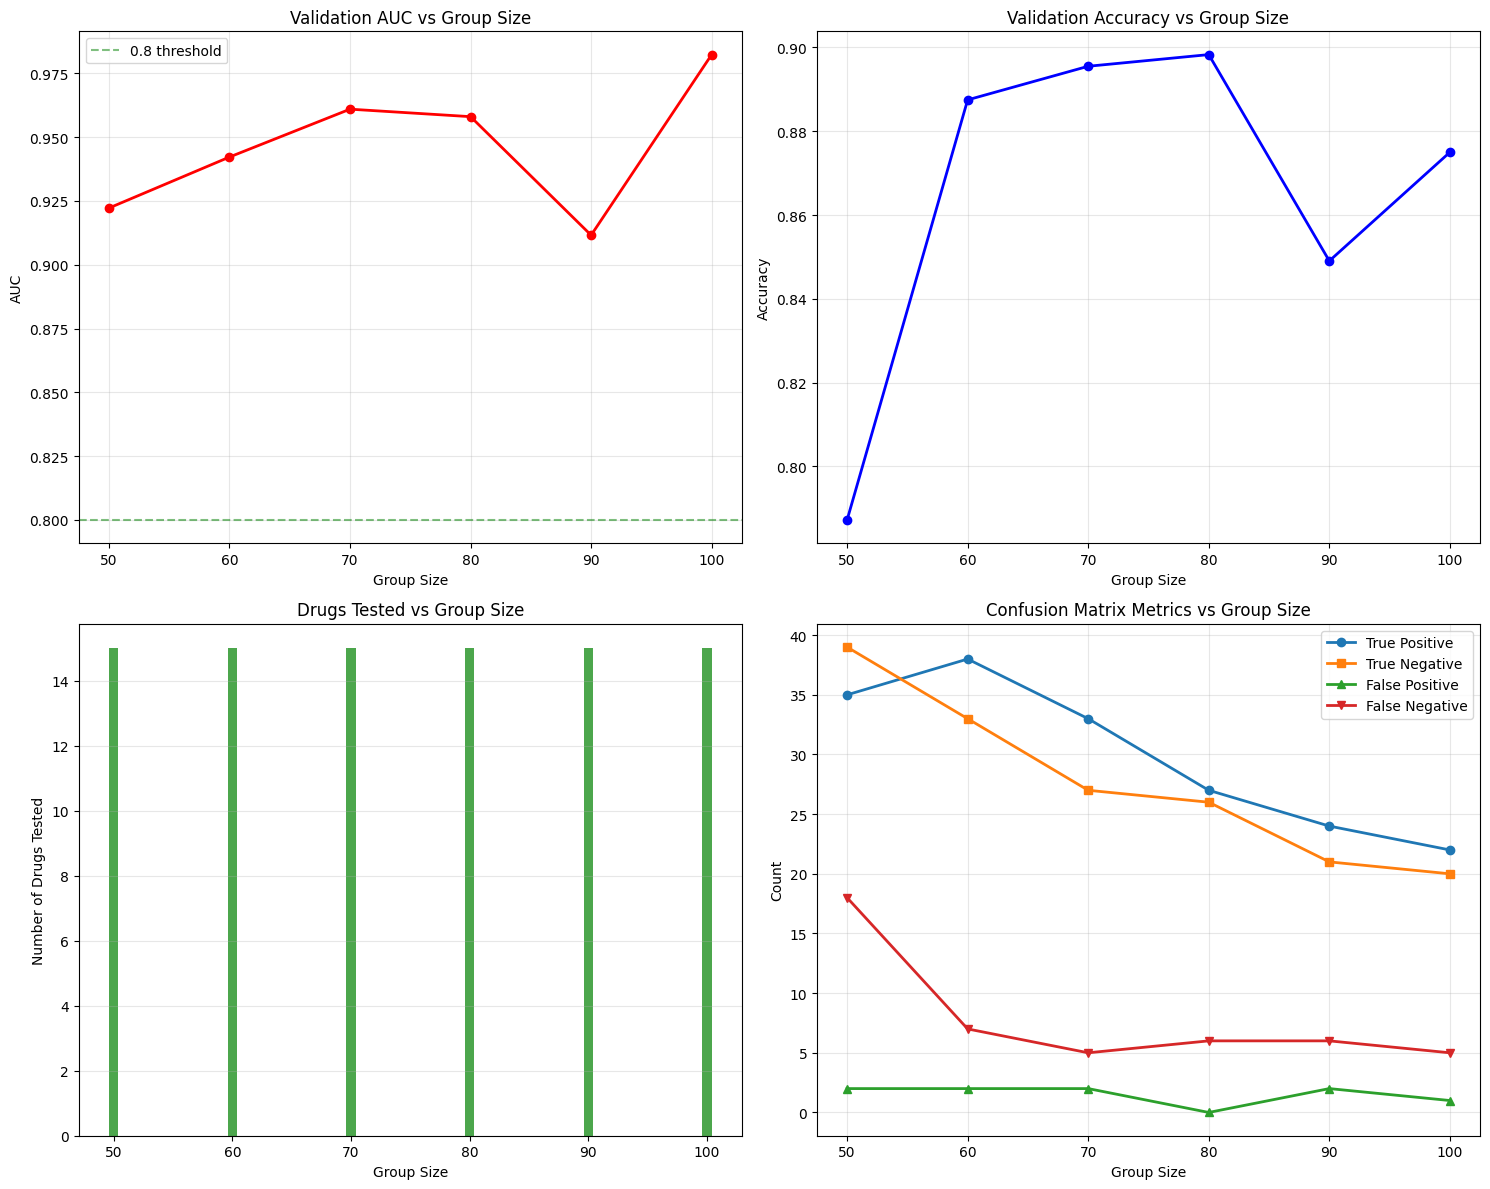


=== Best Validation Performance ===
Best group size: 100
Validation AUC: 0.9824

All validation results saved to: D:\tabPFN\validation
Validation complete!


In [19]:
print("\n=== Generating Validation Summary ===")

if len(validation_results) == 0:
    print("No validation results to summarize!")
else:
    results_df = pd.DataFrame(validation_results)
    results_df.to_csv(validation_results_dir / "validation_summary.csv", index=False)
    
    print("\nValidation Results Summary:")
    print(results_df.to_string(index=False))
    
    # Comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # AUC vs group size
    axes[0, 0].plot(results_df['group_size'], results_df['dmso_auc'], 'ro-', linewidth=2)
    axes[0, 0].set_xlabel('Group Size')
    axes[0, 0].set_ylabel('AUC')
    axes[0, 0].set_title('Validation AUC vs Group Size')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].axhline(0.8, linestyle='--', color='green', alpha=0.5, label='0.8 threshold')
    axes[0, 0].legend()
    
    # Accuracy vs group size
    axes[0, 1].plot(results_df['group_size'], results_df['dmso_acc'], 'bo-', linewidth=2)
    axes[0, 1].set_xlabel('Group Size')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title('Validation Accuracy vs Group Size')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Number of drugs tested
    axes[1, 0].bar(results_df['group_size'], results_df['n_drugs_tested'], color='green', alpha=0.7)
    axes[1, 0].set_xlabel('Group Size')
    axes[1, 0].set_ylabel('Number of Drugs Tested')
    axes[1, 0].set_title('Drugs Tested vs Group Size')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # Confusion matrix metrics
    axes[1, 1].plot(results_df['group_size'], results_df['tp'], 'o-', label='True Positive', linewidth=2)
    axes[1, 1].plot(results_df['group_size'], results_df['tn'], 's-', label='True Negative', linewidth=2)
    axes[1, 1].plot(results_df['group_size'], results_df['fp'], '^-', label='False Positive', linewidth=2)
    axes[1, 1].plot(results_df['group_size'], results_df['fn'], 'v-', label='False Negative', linewidth=2)
    axes[1, 1].set_xlabel('Group Size')
    axes[1, 1].set_ylabel('Count')
    axes[1, 1].set_title('Confusion Matrix Metrics vs Group Size')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(validation_results_dir / 'validation_summary_plots.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Best performing group size
    best_idx = results_df['dmso_auc'].idxmax()
    best_group_size = results_df.loc[best_idx, 'group_size']
    best_auc = results_df.loc[best_idx, 'dmso_auc']
    
    print(f"\n=== Best Validation Performance ===")
    print(f"Best group size: {best_group_size}")
    print(f"Validation AUC: {best_auc:.4f}")
    
    # Save summary
    summary_info = {
        'best_group_size': int(best_group_size),
        'best_validation_auc': float(best_auc),
        'model_type': 'TabPFN',
        'validation_plate': feature_csv.name
    }
    
    with open(validation_results_dir / 'validation_summary.json', 'w') as f:
        json.dump(summary_info, f, indent=2)
    
    print(f"\nAll validation results saved to: {validation_results_dir}")
    print("Validation complete!")